In [60]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from tqdm import tqdm

from models.DAS import DAS
from models.PACT import PSF_PACT
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import gaussian_kernel, wavefront_real
from utils.simulations import *
from utils.utils_torch import get_fourier_coord
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '../data/'

### Load data

In [61]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)

### Preparations

In [62]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Define parameters of the single-body SOS.

In [63]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [64]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

Pick the small patch in the intil pressure image.

In [65]:
def get_coordinates(i, j, l):
    x, y = (j-12)*l / 4, (12-i)*l / 4
    r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
    return x, y, r, phi

i, j = 18, 15
x, y, r, phi = get_coordinates(i, j, l)
k2D, theta2D = get_fourier_coord(n_points=80, l=3.2e-3, device='cpu')
print(r*1e3, phi)

5.366563145999496 2.677945044588987


Define the delays for reconstruction and the elays for visualization, which is a subset of the former.

In [66]:
delays = np.arange(-8e-4, 8e-4, 5e-5)
ids_show = [12, 16, 20, 24, 28]
delays_show = delays[ids_show]
print(delays_show)

[-2.00000000e-04  3.25260652e-19  2.00000000e-04  4.00000000e-04
  6.00000000e-04]


### Uniform SoS

In [67]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

DAS()

In [68]:
with torch.no_grad():
    gt = das(sinogram=torch.tensor(sinogram_uniform, device=device),
             v0=torch.tensor(v0, device=device),
             d_delay=torch.zeros(1, device=device),
             ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [69]:
gt = gt[20*i:20*i+80, 20*j:20*j+80]

### Conventional DAS

In [70]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram, device=device),
                  v0=torch.tensor(1513.0, device=device),
                  d_delay=torch.zeros(1, device=device),
                  ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [71]:
rec_das = rec_das[20*i:20*i+80, 20*j:20*j+80]

### Single Body

In [72]:
psf_pact = PSF_PACT(n_points=80, l=l, n_delays=delays.shape[0], device=device)
psf_pact.to(device)
psf_pact.eval()

das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

wiener = Wiener_Batched(lam=5., device=device)
wiener.to(device)
wiener.eval()

Wiener_Batched()

In [73]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).to(device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

DAS: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]


In [74]:
# gt = IP_img[20*i:20*i+80, 20*j:20*j+80]
w_real = wavefront_real(R, r, phi, v0, v1)
psf_stack = psf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
obs_stack = img_stack[:,20*i:20*i+80, 20*j:20*j+80].unsqueeze(0)
mean = obs_stack.abs().mean()
rec_combined = wiener(obs_stack/mean, psf_stack) * mean
rec_combined = rec_combined.squeeze(0).squeeze(0).detach().cpu().numpy()

In [75]:
recs = []
for idx, delay in zip(ids_show, delays_show):
    psf = psf_stack[:,idx:idx+1,:,:]
    obs = obs_stack[:,idx:idx+1,:,:]
    mean = obs.mean()
    rec = wiener(obs/mean, psf) * mean
    rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
    recs.append(rec)

In [76]:
# plt.subplots(3, 5, figsize=(12, 7))
# for k, (idx, rec) in enumerate(zip(ids_show, recs)):
#     plt.subplot(3, 5, k+1)
#     plt.imshow(obs_stack[:,idx,:,:].squeeze(0).detach().cpu().numpy(), cmap='gray')
#     plt.axis('off')
    
#     plt.subplot(3, 5, k+6)
#     plt.imshow(psf_stack[:,idx,:,:].squeeze(0).detach().cpu().numpy(), cmap='gray')
#     plt.axis('off')
    
#     plt.subplot(3, 5, k+11)
#     plt.imshow(rec, cmap='gray')
#     plt.axis('off')

In [77]:
recs = [normalize(img) for img in recs]
[rec_das, rec_combined, gt] = [normalize(img) for img in [rec_das, rec_combined, gt]]

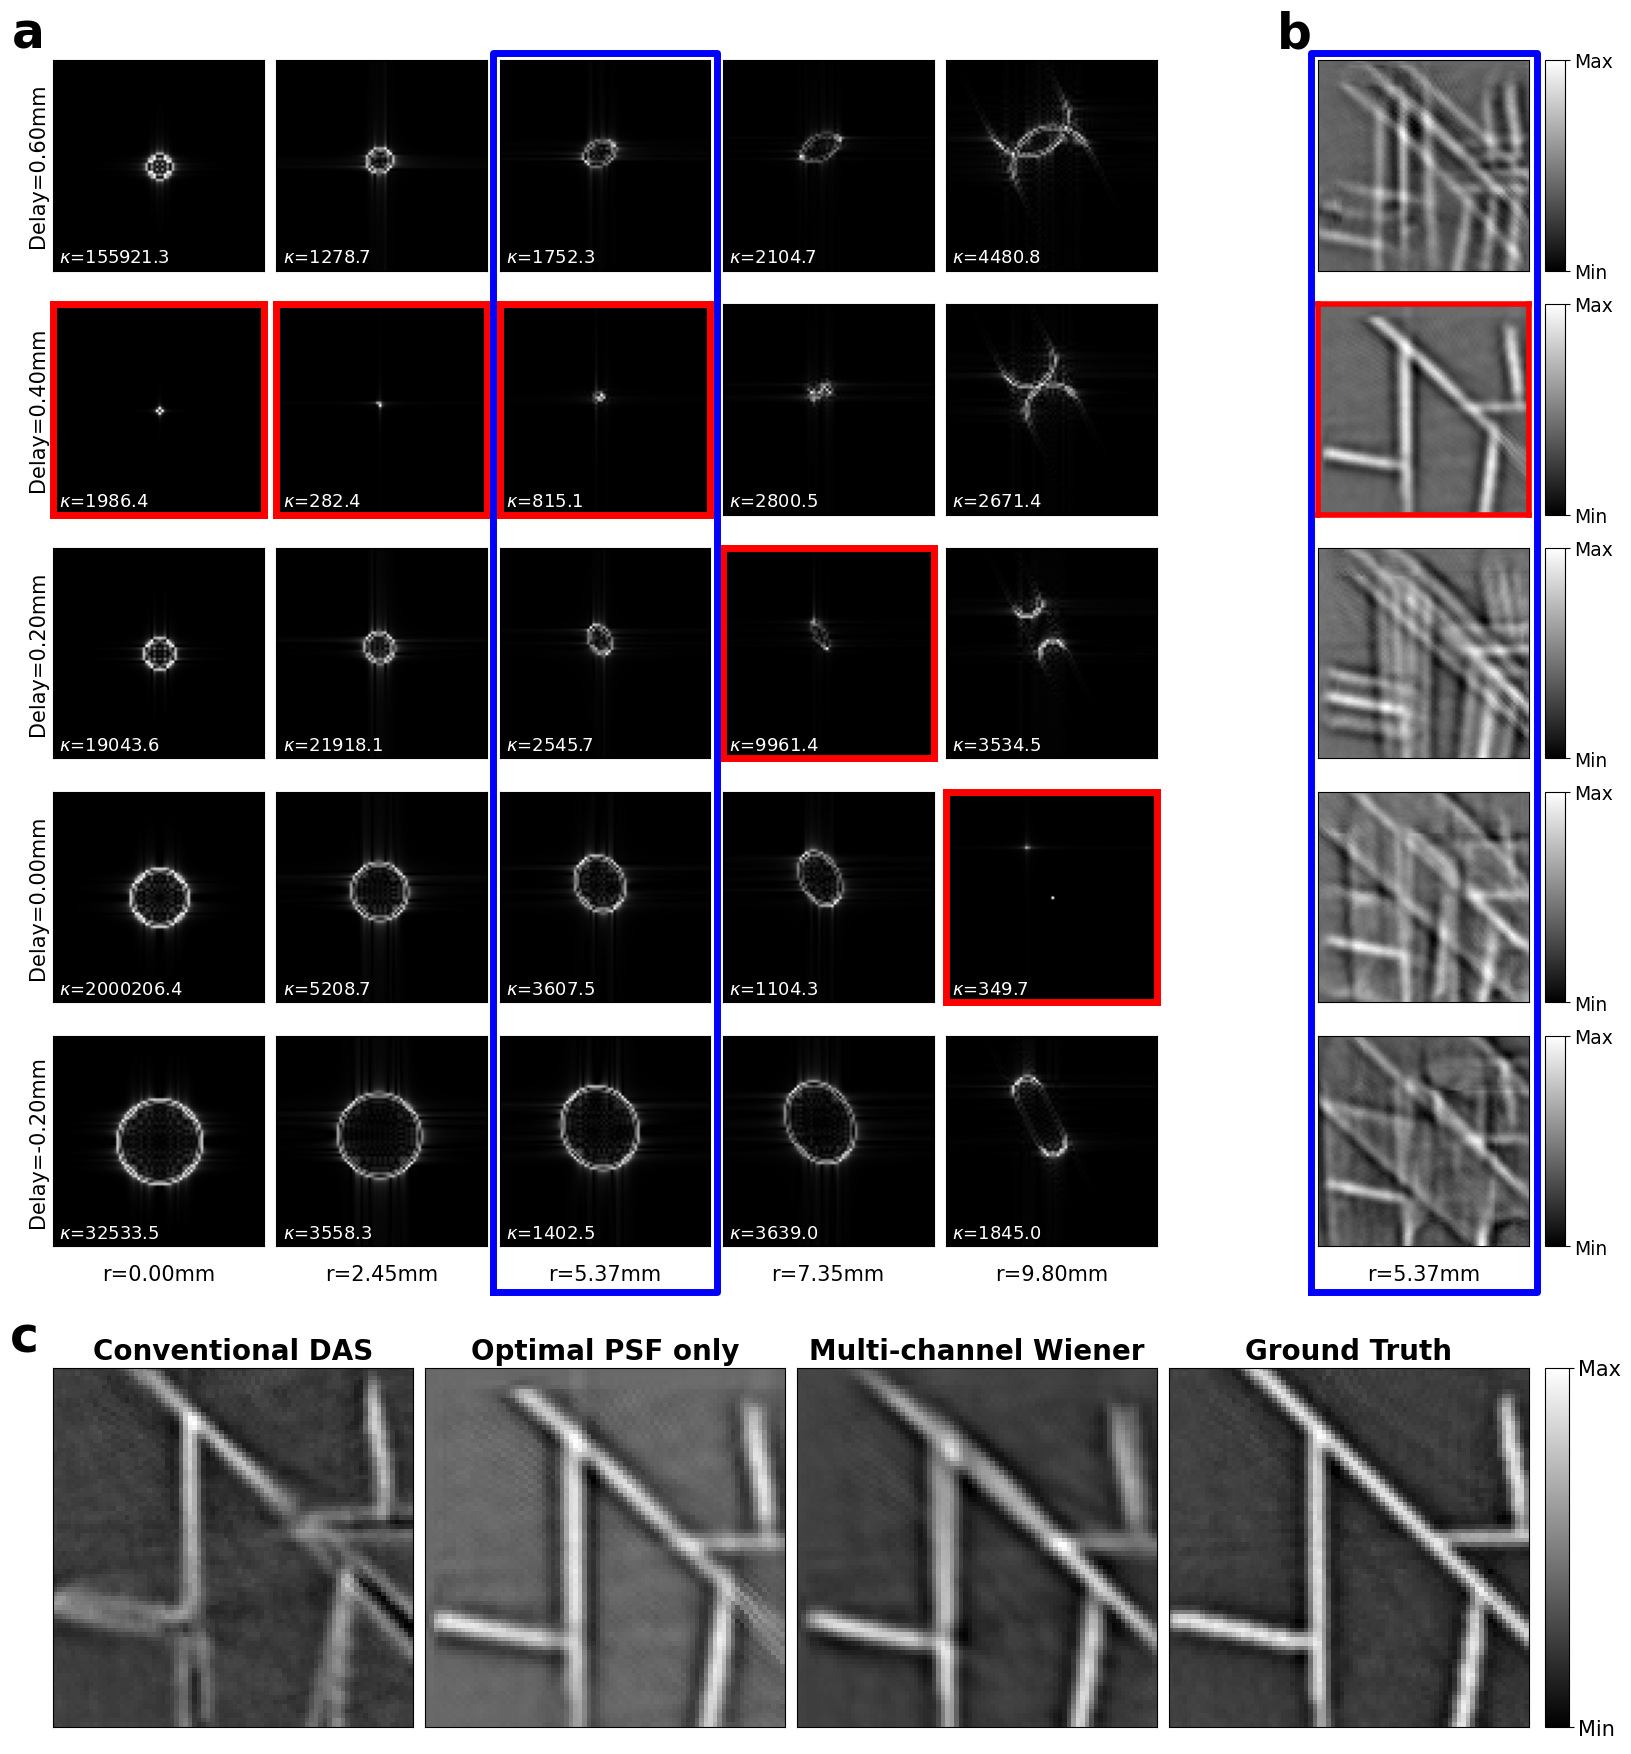

In [78]:
rs = [0, R/4, r, 3*R/4, R]
best_ids = [3,3,3,2,1]

fig, main_ax = plt.subplots(figsize=(20, 22))
gs = GridSpec(21, 21)
norm_img = Normalize(vmin=0, vmax=1)
norm_psf = Normalize(vmin=3e-4, vmax=0.01)
for i, r_i in enumerate(rs):
    w_real = wavefront_real(R, r_i, phi, v0, v1)
    for j, delay in enumerate(delays_show):
        psf = PSF(theta2D, k2D, w_real, delay)
        psf = np.maximum(psf, 1e-5)
        ax = plt.subplot(gs[12-3*j:15-3*j,3*i:3*(i+1)])
        plt.imshow(psf, cmap='gray')#, norm=norm_psf)
        plt.xticks([])
        plt.yticks([])
        plt.title('$\kappa$={:.1f}'.format(condition_number(psf)), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('Delay={:.2f}mm'.format(delays_show[j]*1e3), fontsize=15)
            if j == 4:
                plt.title('a', loc='center', x=-0.12, y=1.02, fontsize=35, fontweight='bold', color='black')
        # elif i == 4:
        #     cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
        #     cb = plt.colorbar(cax=cax)
            # cb.set_ticks([3e-4, 0.04])
            # cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)
        if j == 0:
            ax.set_title('r={:.2f}mm'.format(r_i*1e3), fontsize=15, y=-0.2)
        elif j == best_ids[i]:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(5)

                
for j, delay in enumerate(delays_show):
    ax = plt.subplot(gs[3*(4-j):3*(5-j),17:20])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recs[j], cmap='gray', norm=norm_img)
    if j == 0:
        ax.set_title('r={:.2f}mm'.format(rs[2]*1e3), fontsize=15, y=-0.2)
    elif j == 4:
        plt.title('b', loc='center', x=-0.11, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == best_ids[2]:
        for loc in ['bottom', 'top', 'left', 'right']:
            ax.spines[loc].set_color('red')
            ax.spines[loc].set_linewidth(4)
         
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.set_ticks([0, 1])
    cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)

for j, (img, title) in enumerate(zip([rec_das, recs[best_ids[2]], rec_combined, gt], ['Conventional DAS', 'Optimal PSF only', 'Multi-channel Wiener', 'Ground Truth'])):
    ax = plt.subplot(gs[16:21,5*j:5*(j+1)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray', norm=norm_img)
    plt.title(title, fontsize=20, fontweight='bold')
    if j == 0:
        plt.title('c', loc='left', x=-0.12, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == 3:
        cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([0, 1])
        cb.set_ticklabels(['Min', 'Max'], fontsize=15)

main_ax.set_zorder(20)
main_ax.axis('off')
main_ax.set_xlim(0, 21)
main_ax.set_ylim(0, 21)
y1, y2 = 5.6, 20.96
x1, x2 = 5.96, 8.99
x3, x4 = 17.04, 20.1
main_ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='blue', linewidth=5)
main_ax.plot([x3, x3, x4, x4, x3], [y1, y2, y2, y1, y1], color='blue', linewidth=5)

plt.savefig('figure_refocusing.png', dpi=256, bbox_inches='tight')